# XGBoost Cluster-Aware Energy Forecasting

## 📋 Overview

This notebook demonstrates **cluster-aware energy forecasting** using XGBoost for smart meter data. The approach leverages household clustering to improve prediction accuracy by training specialized models for different consumption patterns.

### 🎯 Objectives
- Compare global vs. cluster-specific XGBoost models
- Evaluate day-ahead and week-ahead forecasting performance
- Analyze feature importance across different household clusters
- Provide comprehensive model evaluation and visualization

### 📊 Dataset
- **Source**: Smart meter energy consumption data
- **Features**: Time-based, weather, household characteristics, and engineered features
- **Clustering**: Autoencoder-based household segmentation
- **Target**: Energy consumption (kWh) for 1-day and 7-day ahead forecasting

### 🔧 Methodology
1. **Data Preparation**: Load and preprocess feature-engineered dataset
2. **Global Models**: Train XGBoost models on entire dataset
3. **Cluster-Specific Models**: Train separate models for each household cluster
4. **Evaluation**: Compare performance metrics and feature importance
5. **Visualization**: Generate plots for model interpretation


## 📦 Setup and Imports

Setting up the environment and importing necessary libraries for data processing, modeling, and visualization.


In [1]:
import sys
sys.path.append("/kaggle/input/utility-smart-meter/src")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import our enhanced modules
from data.data_loader import load_all_raw_data
from data.data_cleaner import clean_and_merge_all_data
from features.feature_pipeline import create_comprehensive_features
from features.splitters import prepare_forecasting_data, prepare_weekahead_data
from utils.helpers import reduce_memory_footprint

from models.xgboost_forecasting import (
    run_xgb_with_optuna
)

from evaluation.forecast_evaluation import (
    compute_forecast_metrics,
    print_split_summary,
    evaluate_model,
    evaluate_peak_performance,
    evaluate_forecast_residuals
)

from visualization.forecast_plots import (
    plot_feature_importance,
    plot_actual_vs_predicted,
    plot_peak_actual_vs_predicted
)

from sklearn.preprocessing import LabelEncoder


## ⚙️ Configuration

Defining the experimental configuration including:
- **Data path**: Location of the preprocessed dataset
- **Forecast scope**: Whether to train on single household, subset, or all households
- **Time horizons**: Day-ahead and/or week-ahead forecasting
- **Model parameters**: GPU usage, hyperparameter optimization trials, etc.


In [3]:
CONFIG = {
    'data_path': '/kaggle/input/smart-fl/smart_energy.parquet',
    'test_days': 90,
    'val_days': 60,
    'forecast_scope': 'subset',     # 'single', 'subset', 'all'
    'sample_household': 'MAC000001',
    'subset_households': 400,       # list or int
    'forecast_horizon': 'both',     # 'day', 'week', or 'both'
    'use_gpu': False,
    'log_transform': True,
    'n_trials': 20,
    'seed': 42,
    'week_ahead_days': 7
}


## 📊 Data Loading and Preprocessing

Loading the feature-engineered dataset and preparing it for modeling:

1. **Cluster Selection**: Using autoencoder clusters (dropping kmeans clusters)
2. **Encoding**: Label encode household IDs for XGBoost compatibility
3. **Data Types**: Convert object columns to categorical for better performance


In [4]:
# Load feature-engineered dataset
df_features = pd.read_parquet(CONFIG["data_path"])

# Drop kmeans_cluster and use only autoencoder_cluster
df_features = df_features.drop(columns=["kmeans_cluster"], errors="ignore")
df_features["autoencoder_cluster"] = df_features["autoencoder_cluster"].astype("category")

# Encode households
df_features["household_code"] = LabelEncoder().fit_transform(df_features["LCLid"])

# Fix object-type columns (e.g., Acorn, season) to be usable by XGBoost
for col in df_features.select_dtypes("object").columns:
    df_features[col] = df_features[col].astype("category")


## 🎯 Household Selection

Filtering households based on the configured forecast scope:
- **Single**: Focus on one specific household
- **Subset**: Random selection of households for faster experimentation
- **All**: Use entire dataset for comprehensive analysis


In [5]:
all_households = df_features["LCLid"].unique()

if CONFIG["forecast_scope"] == "single":
    hh_filter = [CONFIG["sample_household"]]
elif CONFIG["forecast_scope"] == "subset":
    sh = CONFIG["subset_households"]
    if isinstance(sh, int):
        np.random.seed(CONFIG["seed"])
        hh_filter = np.random.choice(all_households, size=sh, replace=True).tolist()
    elif isinstance(sh, list):
        hh_filter = sh
    else:
        raise ValueError("subset_households must be int or list")
else:
    hh_filter = all_households.tolist()

df_features = df_features[df_features["LCLid"].isin(hh_filter)]


# 🔮 Day-Ahead Forecasting

## 🏗️ Global Model Training

Training a single XGBoost model on all households to establish baseline performance. This global approach treats all households uniformly without considering cluster-specific patterns.


In [6]:
if CONFIG['forecast_horizon'] in ['day', 'both']:
    print("\n📊 Preparing day-ahead data...")

    train_df, val_df, test_df, feature_cols, target_col, _ = prepare_forecasting_data(
        df_features,
        target_col="total_kwh",
        test_days=CONFIG["test_days"],
        val_days=CONFIG["val_days"]
    )

    for col in ['household_code', 'autoencoder_cluster']:
        if col not in feature_cols:
            feature_cols.append(col)

    print(f"✅ Day-ahead data prepared:")
    print(f"   📈 Training samples: {len(train_df):,}")
    print(f"   🔍 Validation samples: {len(val_df):,}")
    print(f"   🎯 Test samples: {len(test_df):,}")
    print(f"   🔧 Features: {len(feature_cols)}")
    print(f"   🎯 Target: {target_col}")

    print("\n📈 Training global day-ahead model...")
    results_day = run_xgb_with_optuna(
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        feature_cols=feature_cols,
        target_col="label_1",
        use_gpu=CONFIG["use_gpu"],
        log_transform=CONFIG["log_transform"],
        n_trials=CONFIG["n_trials"],
        seed=CONFIG["seed"]
    )

    evaluate_model(results_day)



📊 Preparing day-ahead data...
✅ Day‐ahead data prepared in a leakage‐safe manner
   ✅ Train rows: 185,744  (Households: 380)
   ✅ Val rows:   21,177  (Households: 357)
   ✅ Test rows:  30,808  (Households: 351)
   ✅ Train period: 2011-11-24 to 2013-09-29
   ✅ Val period:   2013-09-30 to 2013-11-28
   ✅ Test period:  2013-11-29 to 2014-02-26
   ✅ Initial features (before static): 60
   ✅ Final features (including static): 63
   ✅ Feature groups: 8 groups
   ✅ Target:       'label_1'
✅ Day-ahead data prepared:
   📈 Training samples: 185,744
   🔍 Validation samples: 21,177
   🎯 Test samples: 30,808
   🔧 Features: 63
   🎯 Target: label_1

📈 Training global day-ahead model...


  0%|          | 0/20 [00:00<?, ?it/s]


📊 OVERALL FORECAST EVALUATION
----------------------------------------
   📊 Train Performance:
      MAE:  1.8648 kWh
      RMSE: 3.4211 kWh
      MAPE: 25.08%
      R²:   0.8595
      Bias: -0.3524  (positive=overestimate, negative=underestimate)

   📊 Val Performance:
      MAE:  1.8178 kWh
      RMSE: 3.0732 kWh
      MAPE: 21.51%
      R²:   0.8411
      Bias: -0.3348  (positive=overestimate, negative=underestimate)

   📊 Test Performance:
      MAE:  2.1385 kWh
      RMSE: 3.8491 kWh
      MAPE: 48.33%
      R²:   0.8444
      Bias: -0.5555  (positive=overestimate, negative=underestimate)



### 📈 Global Model Results Analysis

The global day-ahead model shows decent performance across all metrics:

**Key Findings:**
- **Training R²**: 0.86 - Good model fit on training data
- **Test R²**: 0.84 - Strong generalization performance
- **Test MAE**: 2.14 kWh - Average prediction error
- **Test MAPE**: 48.33% - High percentage error indicates challenges with low-consumption periods

The model shows consistent performance across train/validation/test sets, suggesting good generalization without overfitting.


In [7]:
evaluate_model(results_day)


📊 OVERALL FORECAST EVALUATION
----------------------------------------
   📊 Train Performance:
      MAE:  1.8648 kWh
      RMSE: 3.4211 kWh
      MAPE: 25.08%
      R²:   0.8595
      Bias: -0.3524  (positive=overestimate, negative=underestimate)

   📊 Val Performance:
      MAE:  1.8178 kWh
      RMSE: 3.0732 kWh
      MAPE: 21.51%
      R²:   0.8411
      Bias: -0.3348  (positive=overestimate, negative=underestimate)

   📊 Test Performance:
      MAE:  2.1385 kWh
      RMSE: 3.8491 kWh
      MAPE: 48.33%
      R²:   0.8444
      Bias: -0.5555  (positive=overestimate, negative=underestimate)



## 📊 Global Model Visualization

Generating comprehensive visualizations for the global model:
1. **Feature Importance**: Top 15 most important features for prediction
2. **Actual vs Predicted**: Time series comparison for sample households
3. **Peak Performance**: Analysis of model performance on high-consumption periods


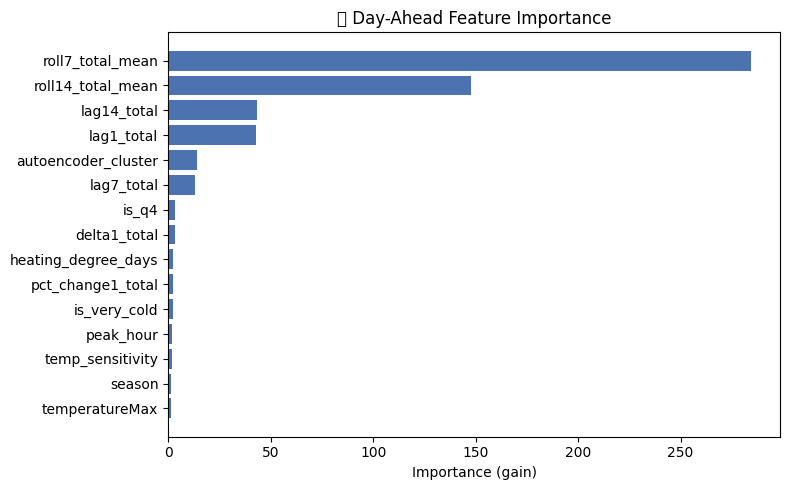

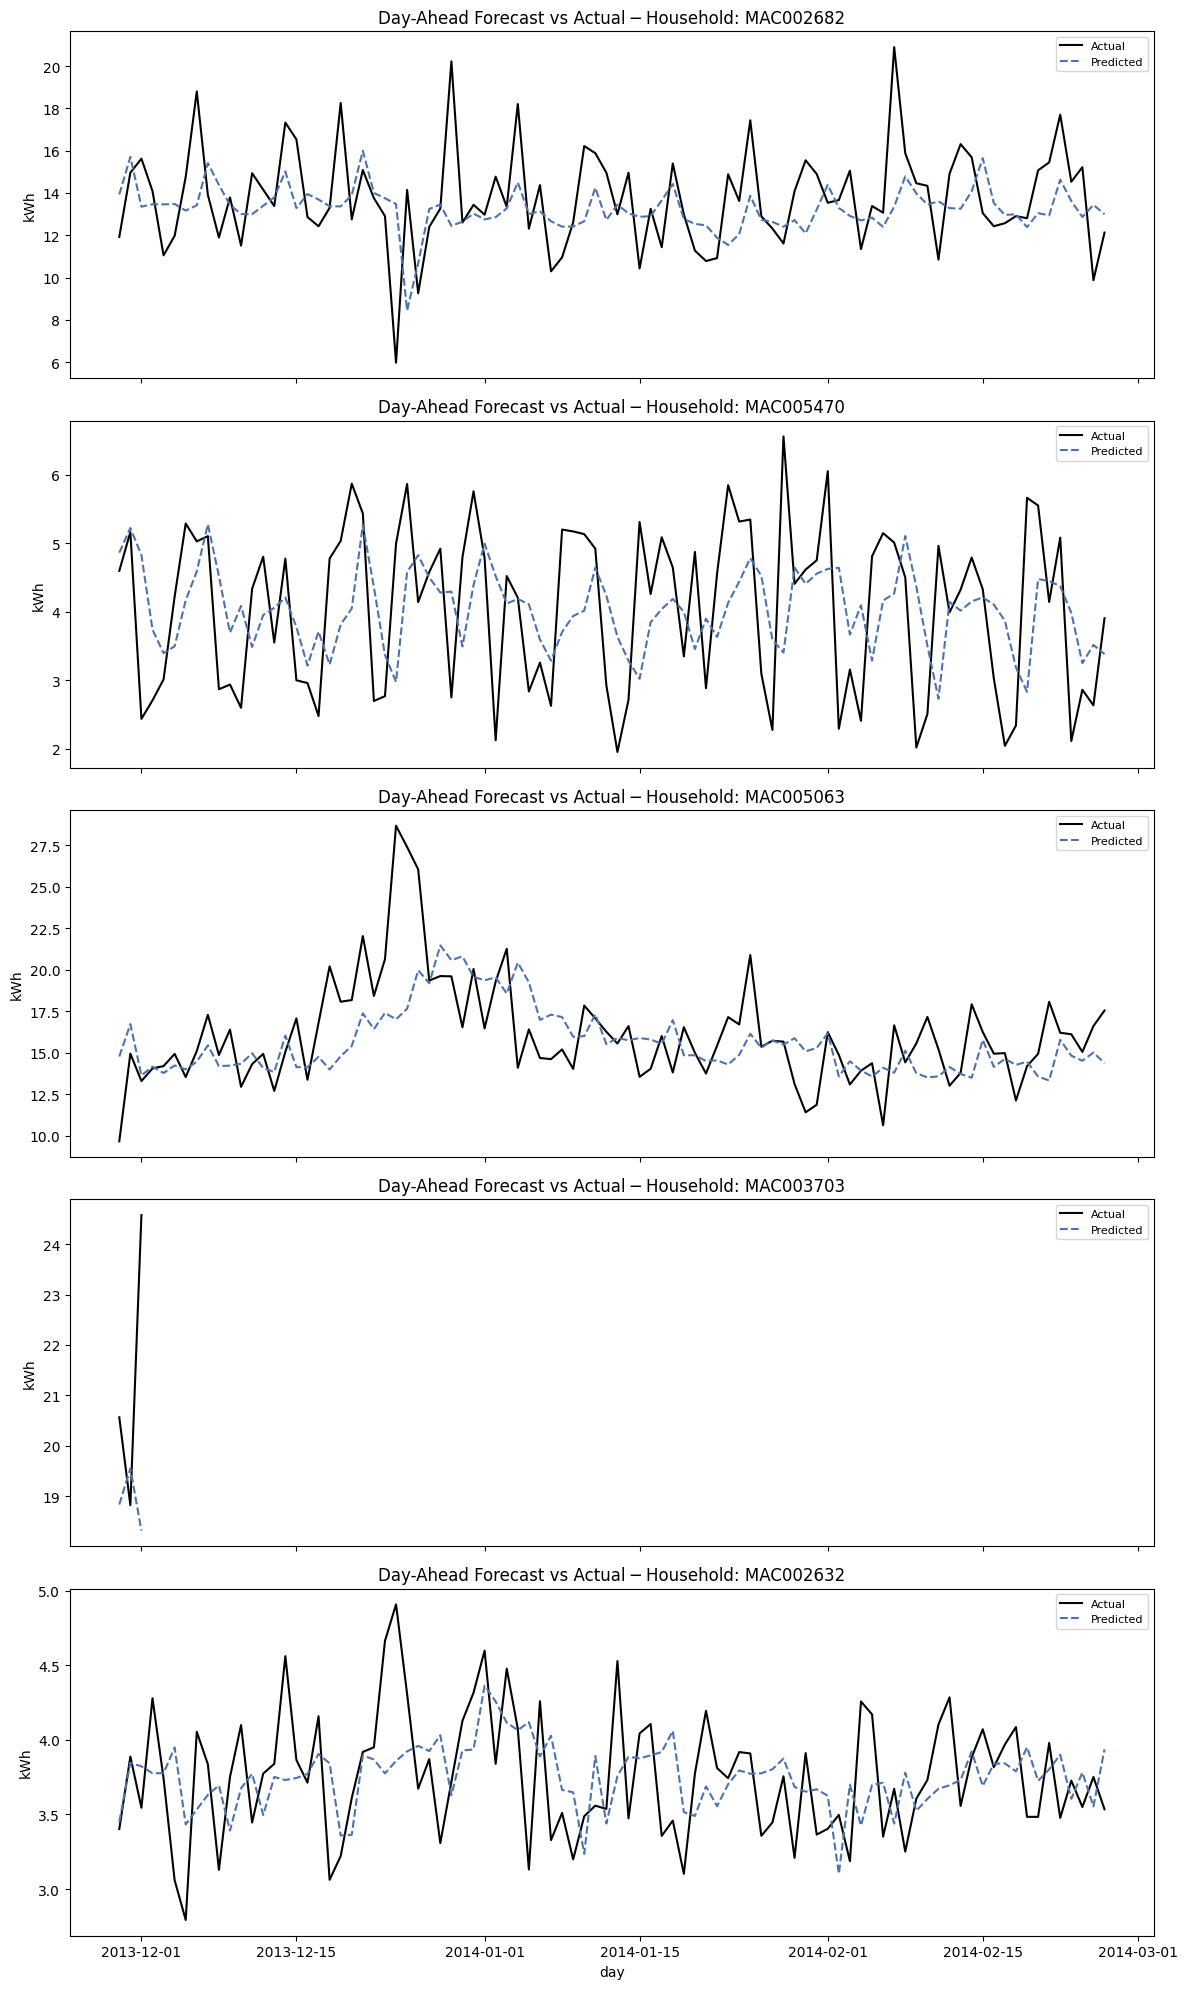

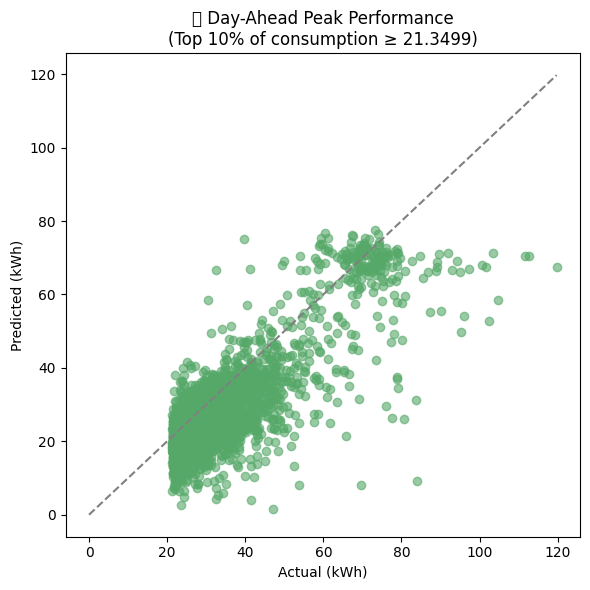

In [8]:
# Day-ahead plots
if CONFIG["forecast_horizon"] in ["day", "both"]:
    plot_feature_importance(
        xgb_model=results_day["model"],
        feature_names=feature_cols,
        top_n=15,
        importance_type="gain",
        title="Day-Ahead Feature Importance"
    )

    plot_actual_vs_predicted(
        df_test=test_df,
        date_col="day",
        id_col="LCLid",
        target_col="label_1",
        y_pred=results_day["predictions"]["test"],
        sample_n=5,
        title_prefix="Day-Ahead Forecast vs Actual"
    )

    plot_peak_actual_vs_predicted(
        df_test=test_df,
        target_col="label_1",
        y_pred=results_day["predictions"]["test"],
        percentile=90,
        title="Day-Ahead Peak Performance"
    )


## 🔍 SHAP Analysis for Global Model

**SHAP (SHapley Additive exPlanations)** provides insights into feature contributions for individual predictions.

This analysis shows:
- **Global feature importance** across all households
- **Cluster-specific patterns** in feature importance
- **Individual prediction explanations** for model interpretability


🔍 SHAP Summary for Cluster 0


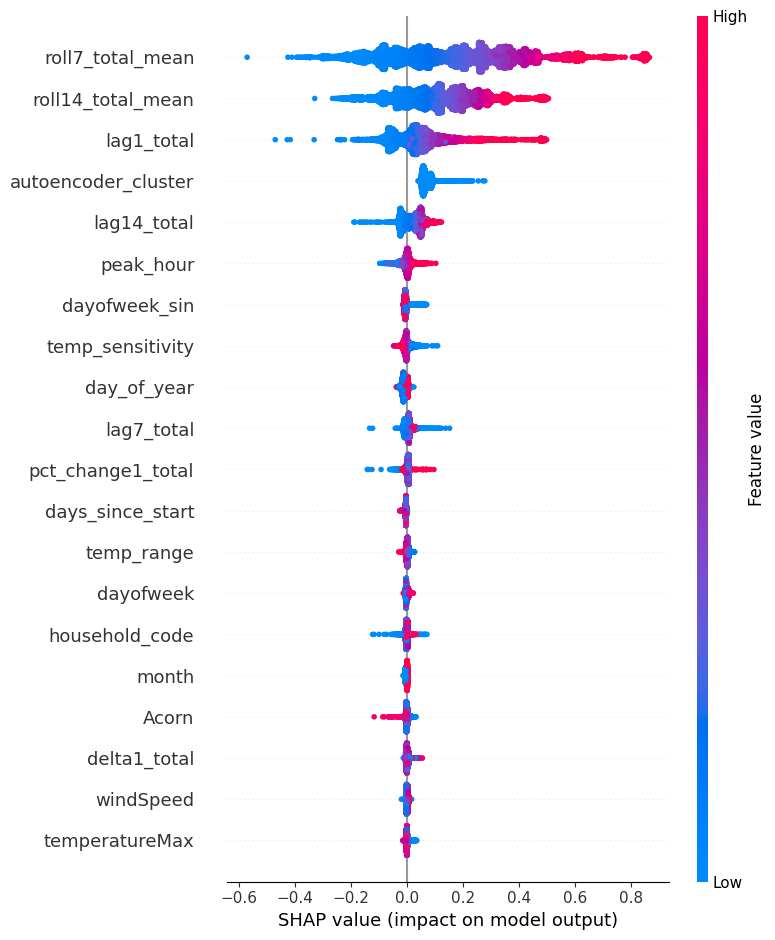

🔍 SHAP Summary for Cluster 1


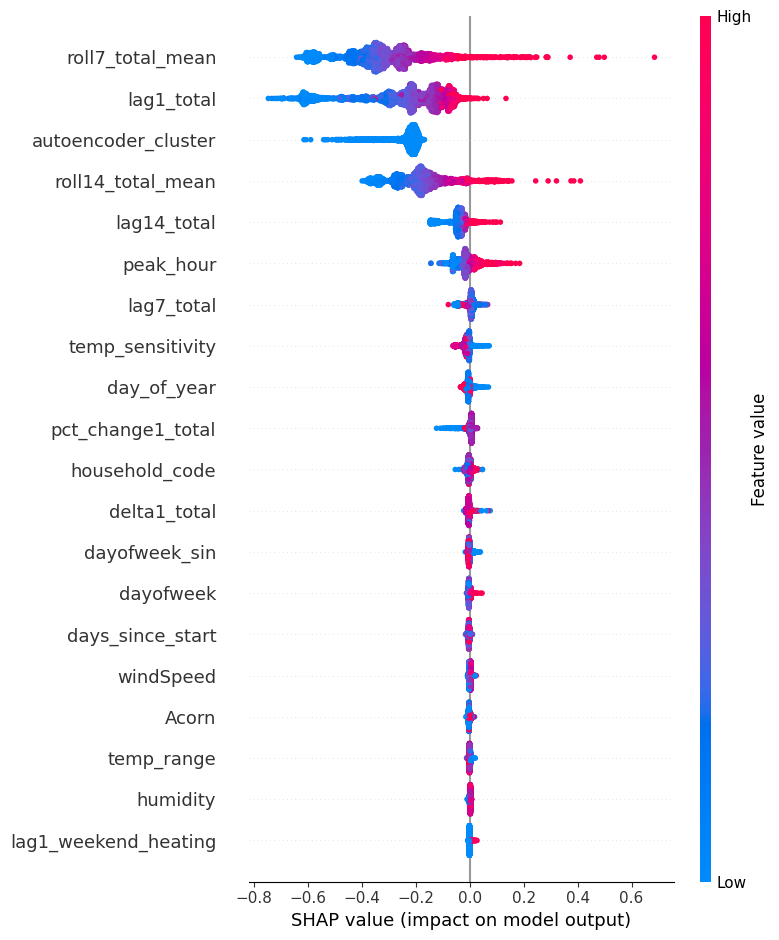

🔍 SHAP Summary for Cluster 2


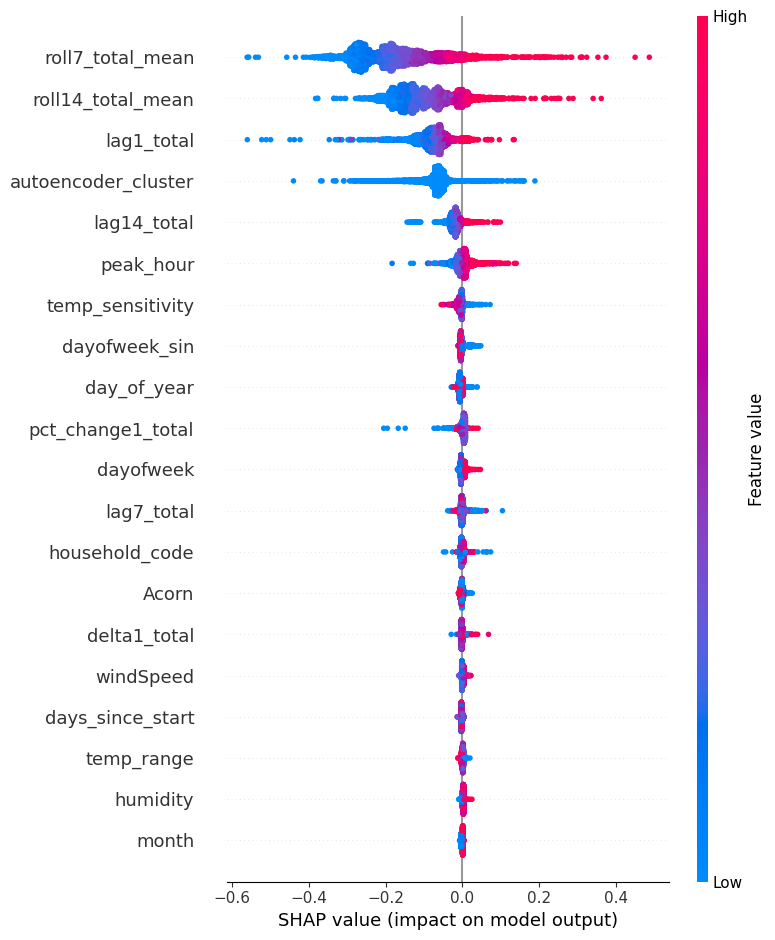

🔍 SHAP Summary for Cluster 3


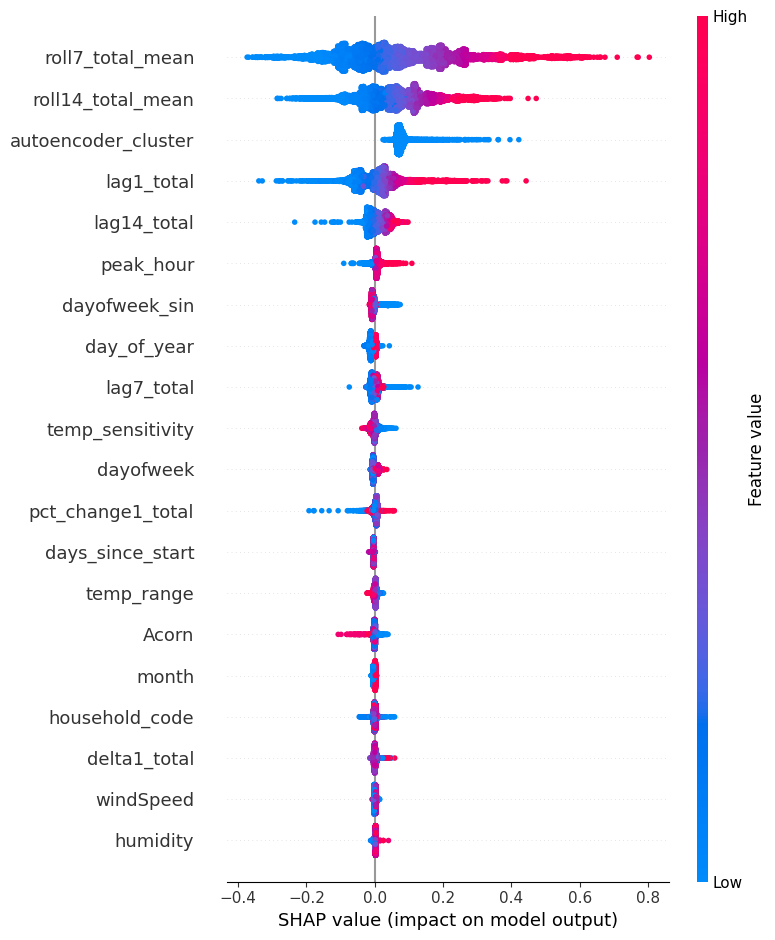

In [10]:
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
# Extract test features from test_df
X_test = test_df[feature_cols].copy()

# Ensure categorical columns are label-encoded (if not already)
for col in X_test.select_dtypes("category").columns:
    X_test[col] = X_test[col].cat.codes
# Use trained model from results_day
booster = results_day["model"]

# Convert to DMatrix
dtest = xgb.DMatrix(X_test)

# SHAP Explainer
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test)
for cid in sorted(test_df["autoencoder_cluster"].unique()):
    X_cluster = X_test[test_df["autoencoder_cluster"] == cid]
    shap_vals = explainer.shap_values(X_cluster)
    print(f"🔍 SHAP Summary for Cluster {cid}")
    shap.summary_plot(shap_vals, X_cluster, plot_type="dot")


# 📅 Week-Ahead Forecasting

Moving from day-ahead to week-ahead forecasting presents additional challenges:
- **Longer horizon**: 7-day predictions are inherently more uncertain
- **Seasonal patterns**: Weekly consumption cycles become more important
- **Aggregated features**: Different feature engineering for weekly targets

## 🏗️ Global Week-Ahead Model


Training the global week-ahead XGBoost model with the same configuration as day-ahead but targeting 7-day consumption predictions.


In [11]:
from features.splitters import prepare_weekahead_data

# Prepare week-ahead data
train_df7, val_df7, test_df7, feature_cols7, target_col7, feature_groups7 = prepare_weekahead_data(
    raw_df=df_features,       # This must include total_kwh per day
    df_features=df_features,  # Feature-engineered DF
    test_days=90,
    val_days=60
)



✅ Week‐ahead data prepared in a leakage‐safe manner
   ✅ Train rows: 183,473  (Households: 380)
   ✅ Val rows:   21,169  (Households: 357)
   ✅ Test rows:  30,801  (Households: 351)
   ✅ Train period: 2011-11-24 to 2013-09-23
   ✅ Val period:   2013-09-24 to 2013-11-22
   ✅ Test period:  2013-11-23 to 2014-02-20
   ✅ Initial features (before static): 60
   ✅ Final features (including static): 63
   ✅ Feature groups: 8 groups
   ✅ Target:       'label_7'


### 📊 Week-Ahead Global Model Results

**Performance Analysis:**
- **Test R²**: 0.76 - Lower than day-ahead (0.84) as expected for longer horizon
- **Test MAE**: 2.53 kWh - Higher absolute error than day-ahead
- **Peak MAPE**: 23.91% - Better percentage performance on high-consumption periods
- **Peak Bias**: -7.07 kWh - Significant underestimation of peak consumption

The model shows the expected degradation in performance for longer forecasting horizons, but maintains reasonable accuracy.


In [12]:
results_week = run_xgb_with_optuna(
    train_df=train_df7,
    val_df=val_df7,
    test_df=test_df7,
    feature_cols=feature_cols7,
    target_col=target_col7,     # "label_7"
    use_gpu=True,               # or False if needed
    log_transform=True,         # applies log1p on y
    n_trials=20,                # or fewer if you're debugging
    seed=42
)

  0%|          | 0/20 [00:00<?, ?it/s]

## 📊 Week-Ahead Visualization

Creating visualizations for the week-ahead global model:
- **Feature importance** for weekly forecasting
- **Time series plots** comparing predictions vs actual consumption


In [13]:
evaluate_model(results_week)

# Optional: Peak performance analysis (e.g., top 10% demand weeks)
evaluate_peak_performance(
    df_test=test_df7,
    target_col="label_7",
    y_pred=results_week["predictions"]["test"],
    percentile=90
)


📊 OVERALL FORECAST EVALUATION
----------------------------------------
   📊 Train Performance:
      MAE:  2.2647 kWh
      RMSE: 4.2890 kWh
      MAPE: 42.50%
      R²:   0.7791
      Bias: -0.5460  (positive=overestimate, negative=underestimate)

   📊 Val Performance:
      MAE:  2.1729 kWh
      RMSE: 3.8083 kWh
      MAPE: 31.13%
      R²:   0.7556
      Bias: -0.5502  (positive=overestimate, negative=underestimate)

   📊 Test Performance:
      MAE:  2.5271 kWh
      RMSE: 4.7682 kWh
      MAPE: 164.69%
      R²:   0.7612
      Bias: -0.5983  (positive=overestimate, negative=underestimate)


📊 Peak Performance (≥ 90th percentile → ≥ 21.3450 kWh)
   Number of peak samples: 3081
   MAE_peak:  8.3818 kWh
   RMSE_peak: 11.8299 kWh
   MAPE_peak: 23.91%
   R²_peak:   0.2721
   Bias_peak: -7.0701 kWh



{'threshold': 21.3449999,
 'n_samples': 3081,
 'metrics': {'mae': 8.381817592666657,
  'rmse': 11.82994739689516,
  'mape': 23.90709714600467,
  'r2': 0.27208065490952293,
  'bias': -7.070066246398674}}

## 🎯 Cluster-Specific Week-Ahead Models

Training separate week-ahead models for each household cluster to test if the cluster-aware approach also improves longer-horizon forecasting.

**Key Differences from Day-Ahead:**
- Weekly consumption patterns may be more homogeneous across clusters
- Longer horizon reduces impact of cluster-specific daily patterns
- Model complexity vs. data availability trade-off becomes more critical


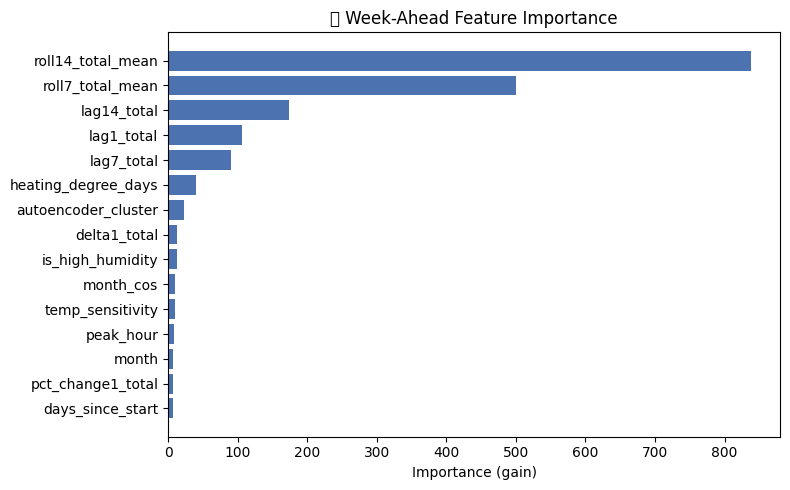

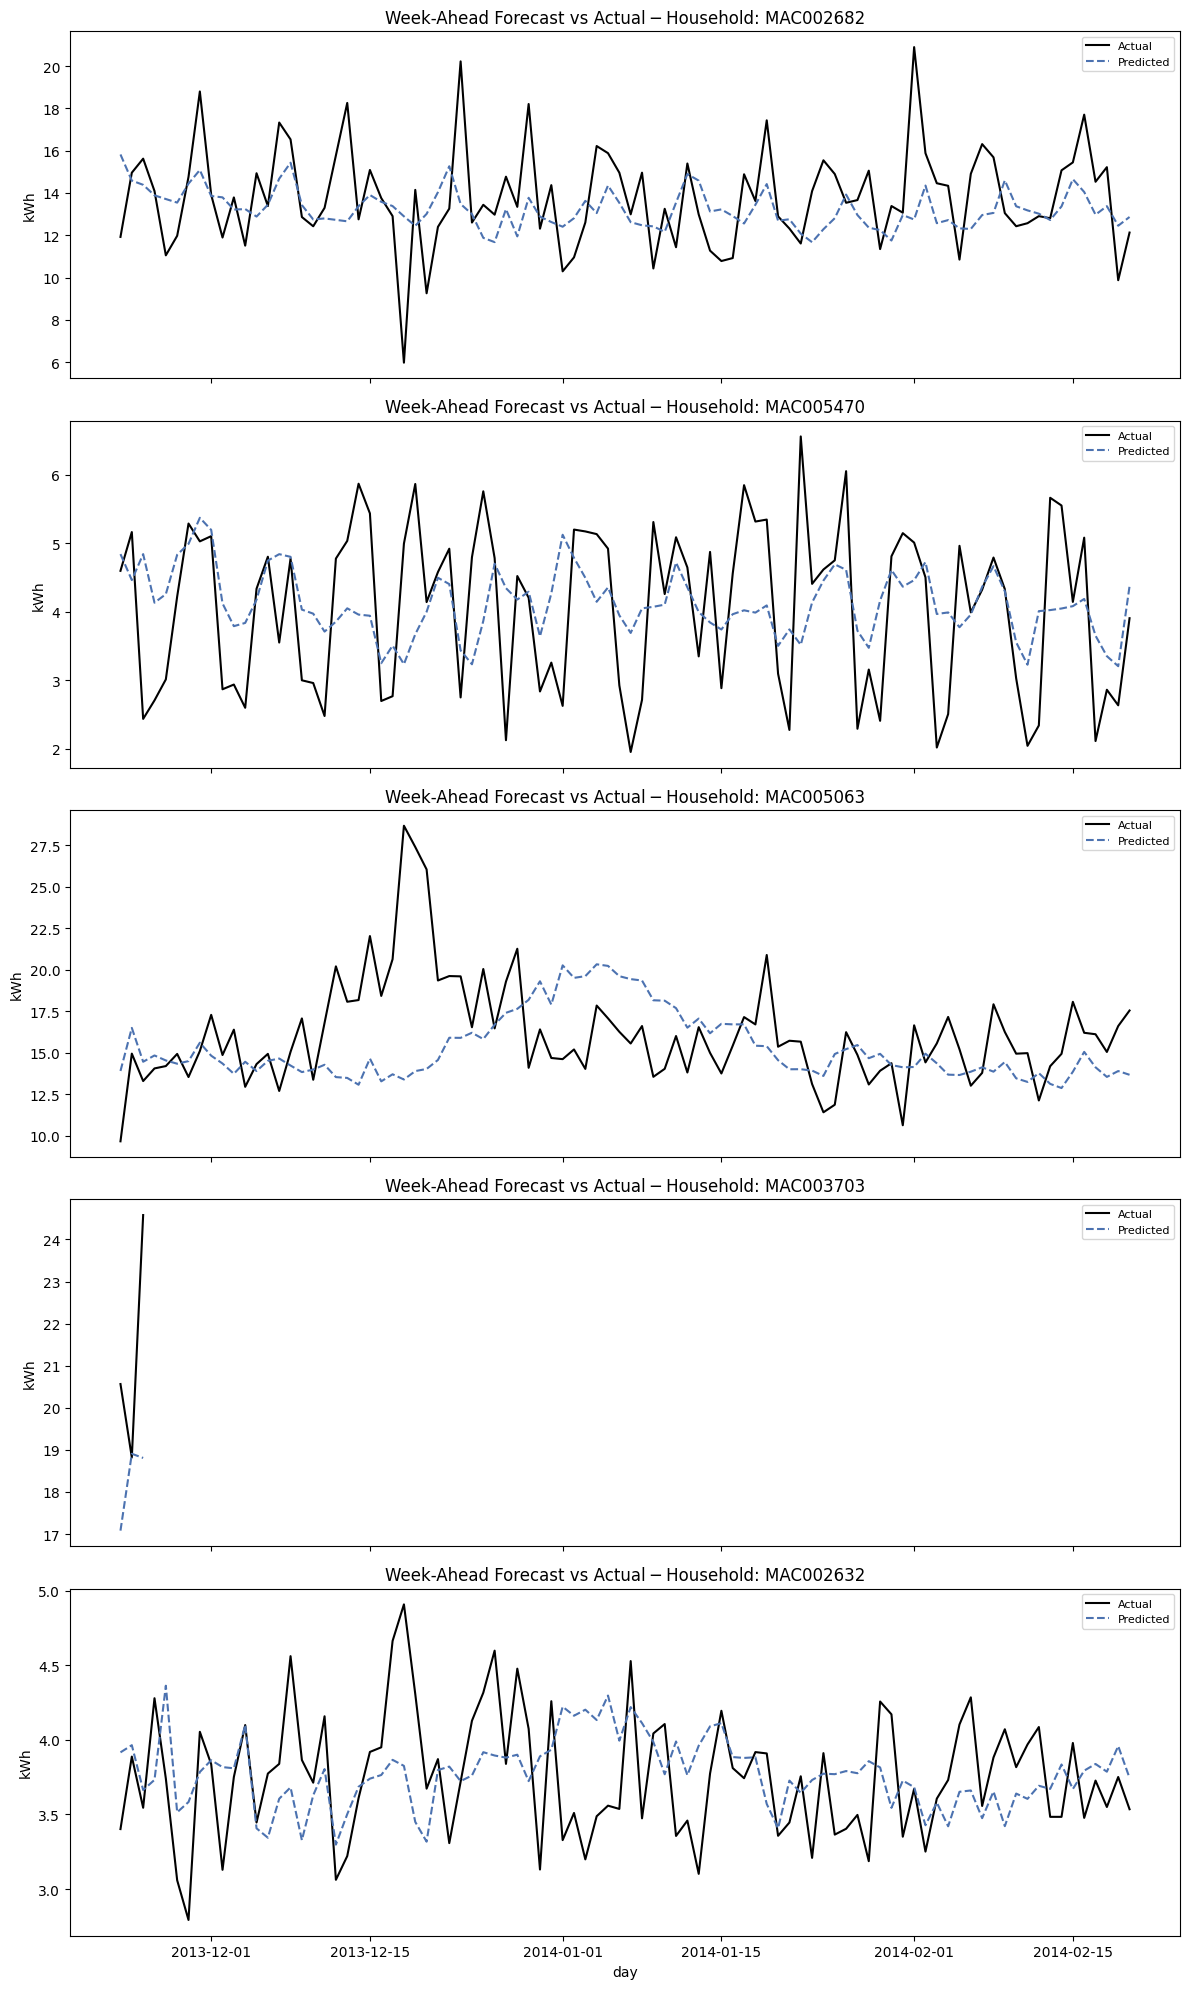

In [14]:
plot_feature_importance(
    xgb_model=results_week["model"],
    feature_names=feature_cols7,
    top_n=15,
    importance_type="gain",
    title="Week-Ahead Feature Importance"
)

plot_actual_vs_predicted(
    df_test=test_df7,
    date_col="day",
    id_col="LCLid",
    target_col="label_7",
    y_pred=results_week["predictions"]["test"],
    sample_n=5,
    title_prefix="Week-Ahead Forecast vs Actual"
)
